<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

# Doubly Robust Learner and Interpretability

Double Machine Learning (DML) is an algorithm that applies arbitrary machine learning methods
to fit the treatment and response, then uses a linear model to predict the response residuals
from the treatment residuals.

To run this jupyter notebook, you need to clone and setup the EconML library version from the branch:
https://github.com/microsoft/EconML/tree/vasilis/cate_interpreters

For more information on these classes you can locally build the documentation for this branch using the instructions from the README: i.e. 

`python setup.py build_sphinx -W -E -a`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
## Ignore warnings
import warnings
warnings.filterwarnings('ignore') 

In [3]:
# Helper imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Generating Data

In [4]:
import scipy.special

np.random.seed(123)
n=2000 # number of raw samples
d=10 # number of binary features + 1

# Generating random segments aka binary features. We will use features 0,...,3 for heterogeneity.
# The rest for controls. Just as an example.
X = np.random.binomial(1, .5, size=(n, d))
# Generating an imbalanced A/B test
T = np.random.binomial(1, scipy.special.expit(X[:, 0]))
# Generating an outcome with treatment effect heterogeneity. The first binary feature creates heterogeneity
# We also have confounding on the first variable. We also have heteroskedastic errors.
y = (-1 + 2 * X[:, 0]) * T + X[:, 0] + (1*X[:, 0] + 1)*np.random.normal(0, 1, size=(n,))

# Applying the LinearDRLearner

In [5]:
from econml.utilities import WeightedLassoCV
from econml.drlearner import LinearDRLearner
from sklearn.linear_model import LogisticRegressionCV

# One can replace model_y and model_t with any scikit-learn regressor and classifier correspondingly
# as long as it accepts the sample_weight keyword argument at fit time.
est = LinearDRLearner(model_regression=WeightedLassoCV(cv=3),
                      model_propensity=LogisticRegressionCV(cv=3))
est.fit(y, T, X=X[:, :4], W=X[:, 4:], inference='statsmodels')

In [6]:
# Treatment Effect of particular segments
est.effect(np.array([[1, 0, 0, 0]])) # effect of segment with features [1, 0, 0, 0]

array([1.1522786])

In [7]:
# Confidence interval for effect
est.effect_interval(np.array([[1, 0, 0, 0]])) # effect of segment with features [1, 0, 0, 0]

(array([0.86835786]), array([1.43619934]))

In [8]:
# Getting the coefficients of the linear CATE model together with the corresponding feature names
print(np.array(list(zip(est.cate_feature_names(['A', 'B', 'C', 'D']), est.coef_(T=1)))))
print(est.intercept_(T=1))

[['A' '2.1212873928962197']
 ['B' '-0.0021304810086630876']
 ['C' '-0.152891945848316']
 ['D' '0.019134933082687544']]
-0.9690087902764521


## Non-Linear CATE Models

In [9]:
from econml.utilities import WeightedLassoCV
from econml.drlearner import LinearDRLearner
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures

# One can replace model_y and model_t with any scikit-learn regressor and classifier correspondingly
# as long as it accepts the sample_weight keyword argument at fit time.
est = LinearDRLearner(model_regression=WeightedLassoCV(cv=3),
                      model_propensity=LogisticRegressionCV(cv=3),
                      featurizer=PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))
est.fit(y, T, X=X[:, :4], W=X[:, 4:], inference='statsmodels')

In [10]:
# Getting the confidence intervals of the coefficients of the CATE model
# together with the corresponding feature names.
# coef__interval returns a tuple of lower, upper, Hence need to transpose so as to zip with feature_names
print(np.array(list(zip(est.cate_feature_names(['A', 'B', 'C', 'D']),
                        est.coef_(T=1),
                        np.array(est.coef__interval(T=1)).T))))
print(est.intercept_(T=1), est.intercept__interval(T=1))

[['A' 1.8887887379942847 array([1.3995444 , 2.37803308])]
 ['B' -0.1240329295592617 array([-0.60410898,  0.35604312])]
 ['C' -0.10583122339272566 array([-0.58396286,  0.37230041])]
 ['D' 0.06815918750486472 array([-0.41562953,  0.5519479 ])]
 ['A B' 0.34688508570675386 array([-0.12288934,  0.81665952])]
 ['A C' 0.09291821408587664 array([-0.37683898,  0.5626754 ])]
 ['A D' -0.10832797510983816 array([-0.57765624,  0.36100029])]
 ['B C' -0.17680964708891678 array([-0.64711963,  0.29350034])]
 ['B D' 0.08166873780265388 array([-0.38811293,  0.55145041])]
 ['C D' 0.05052880762619694 array([-0.41955336,  0.52061098])]]
-0.9590331852817858 (-1.3789602792861728, -0.539106091277399)


# Tree Interpretation of the CATE Model

In [11]:
from econml.cate_interpreter import SingleTreeCateInterpreter

In [12]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=1)
# We interpret the CATE models behavior on the distribution of heterogeneity features
intrp.interpret(est, X[:, :4])

In [13]:
# exporting to a dot file
intrp.export_graphviz(out_file='cate_tree.dot', feature_names=['A', 'B', 'C', 'D'])

In [14]:
# or we can directly render. Requires the graphviz python library
intrp.render(out_file='dr_cate_tree', format='pdf', view=True, feature_names=['A', 'B', 'C', 'D'])

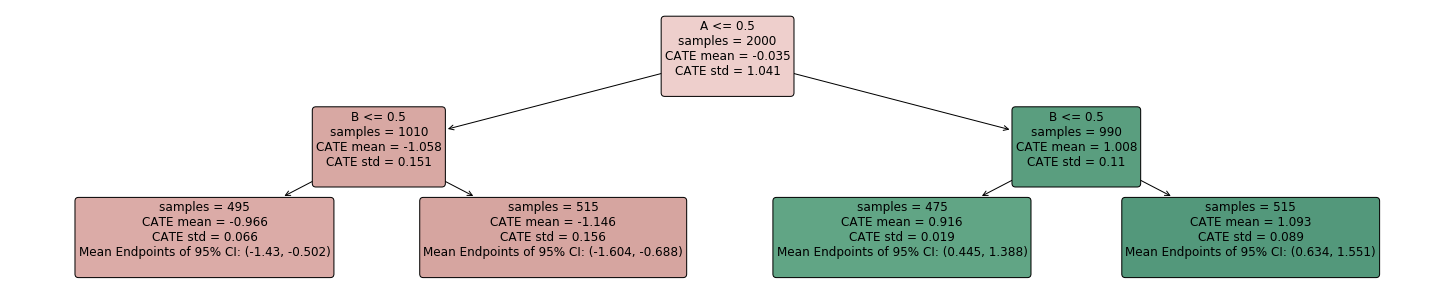

In [15]:
# or we can also plot inline with matplotlib. a bit uglier
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=['A', 'B', 'C', 'D'], fontsize=12)
plt.show()

# Tree Based Treatment Policy Based on CATE Model

In [16]:
from econml.cate_interpreter import SingleTreePolicyInterpreter

In [17]:
intrp = SingleTreePolicyInterpreter(risk_level=0.05, max_depth=2, min_samples_leaf=1, min_impurity_decrease=.001)
# We find a tree based treatment policy based on the CATE model
# sample_treatment_costs is the cost of treatment. Policy will treat if effect is above this cost.
# It can also be an array that has a different cost for each sample. In case treating different segments
# has different cost.
intrp.interpret(est, X[:, :4],
                sample_treatment_costs=0) 

In [18]:
# exporting to a dot file
intrp.export_graphviz(out_file='cate_tree.dot', feature_names=['A', 'B', 'C', 'D'])

In [19]:
# or we can directly render. Requires the graphviz python library
intrp.render(out_file='dr_policy_tree', format='pdf', view=True, feature_names=['A', 'B', 'C', 'D'])

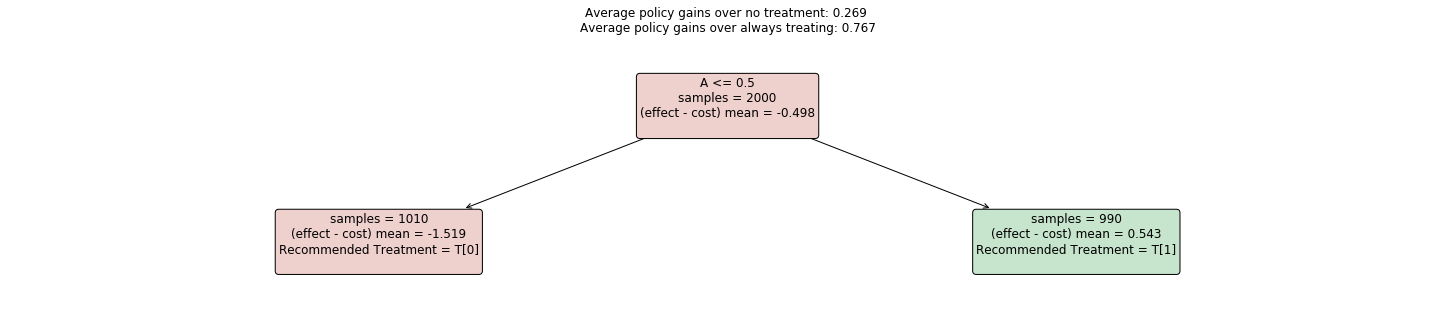

In [20]:
# or we can also plot inline with matplotlib. a bit uglier
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=['A', 'B', 'C', 'D'], fontsize=12)
plt.show()

# SHAP Interpretability with Final Tree CATE Model

In [21]:
# We need to use a scikit-learn final model
from econml.drlearner import DRLearner
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier

# One can replace model_y and model_t with any scikit-learn regressor and classifier correspondingly
# as long as it accepts the sample_weight keyword argument at fit time.
est = DRLearner(model_regression=GradientBoostingRegressor(max_depth=3, n_estimators=100, min_samples_leaf=30),
                model_propensity=GradientBoostingClassifier(max_depth=3, n_estimators=100, min_samples_leaf=30),
                model_final=RandomForestRegressor(max_depth=3, n_estimators=100, min_samples_leaf=30))
est.fit(y, T, X=X[:, :4], W=X[:, 4:])

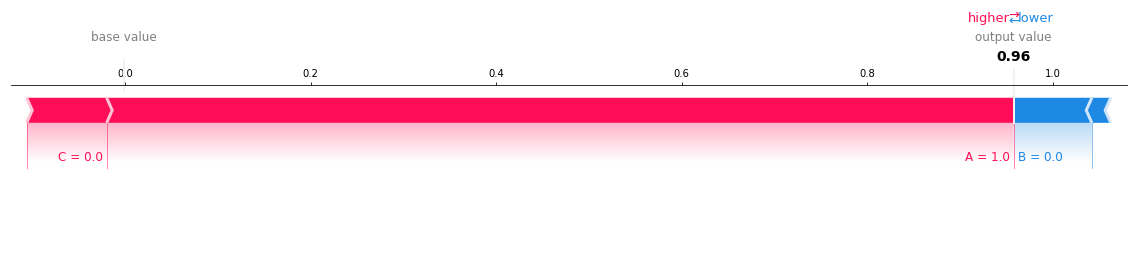

In [22]:
import shap
import pandas as pd

Xdf = pd.DataFrame(X[:, :4], columns=['A', 'B', 'C', 'D'])
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(est.model_cate(T=1))
shap_values = explainer.shap_values(Xdf)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], Xdf.iloc[0,:], matplotlib=True)

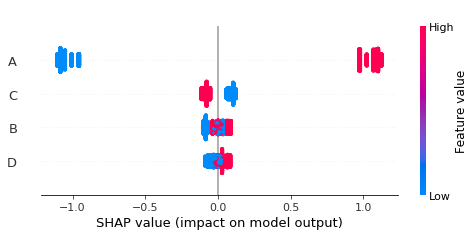

In [23]:
shap.summary_plot(shap_values, Xdf)